In [11]:
import pandas_datareader.data as web
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
import mysql.dataadapter as dataAdapter
sns.set_theme()


Set start and end time. It is one year by default

In [12]:
end = datetime.date.today()
start = end - datetime.timedelta(700)


Stock class 

In [13]:
class Stock:
    def __init__(self,  label):
        self.label = label
        self.stockData = self.getStockData(label)

    def getStockData(self, label):
        stock = web.DataReader(label, 'yahoo', start, end)[
            ['Close', 'Volume']].round(2)
        addMAData(stock)
        addMAScore(stock)
        addPriceScore(stock)
        addSumScore(stock)
        addPriceDelta(stock)
        return stock


function to calculate MA and EMA, Score 

In [14]:
def caculateEMA(prices, days, smoothing=2):
    if len(prices) < days:
        return [np.nan]*len(prices)
    ema = [sum(prices[:days]) / days]
    for price in prices[days:]:
        ema.append((price * (smoothing / (1 + days))) +
                   ema[-1] * (1 - (smoothing / (1 + days))))
    return [np.nan]*(days-1)+ema


def caculateMA(prices, days):
    if len(prices) < days:
        return [np.nan]*len(prices)
    return prices.rolling(days).mean()


def addMAData(prices_df):
    prices_df['MA20'] = caculateMA(prices_df['Close'], 20)
    prices_df['MA60'] = caculateMA(prices_df['Close'], 60)
    prices_df['MA120'] = caculateMA(prices_df['Close'], 120)
    prices_df['MA250'] = caculateMA(prices_df['Close'], 250)
    prices_df['EMA20'] = caculateEMA(prices_df['Close'], 20)
    prices_df['EMA60'] = caculateEMA(prices_df['Close'], 60)
    prices_df['EMA120'] = caculateEMA(prices_df['Close'], 120)
    prices_df['EMA250'] = caculateEMA(prices_df['Close'], 250)


def caculateOneDayPriceScore(prices):
    score = 0
    fullScore = 200
    dummy = {'Close': np.nan,
             'MA20': np.nan,
             'MA60': np.nan,
             'MA120': np.nan,
             'MA250': np.nan,
             'EMA20': np.nan,
             'EMA60': np.nan,
             'EMA120': np.nan,
             'EMA250': np.nan,
             }
    priceToday = prices.iloc[-1] if(len(prices) > 0) else dummy
    price20 = prices.iloc[-20] if len(prices) >= 20 else dummy
    price60 = prices.iloc[-60] if len(prices) >= 60 else dummy
    price120 = prices.iloc[-120] if len(prices) >= 120 else dummy
    price250 = prices.iloc[-250]if len(prices) >= 250 else dummy
    if priceToday['Close'] >= priceToday['EMA250']:
        score += 40
    if priceToday['Close'] >= priceToday['EMA120']:
        score += 30
    if priceToday['Close'] >= priceToday['EMA60']:
        score += 20
    if priceToday['Close'] >= priceToday['EMA20']:
        score += 10
    if priceToday['Close'] >= price250['Close']:
        score += 40
    if priceToday['Close'] >= price120['Close']:
        score += 30
    if priceToday['Close'] >= price60['Close']:
        score += 20
    if priceToday['Close'] >= price20['Close']:
        score += 10
    # pass score  180=>90
    return score*100/fullScore


def addPriceDelta(pricesDF):
    pricesDeltaList = ['']
    pricesDeltaPercentageList = [0]
    for i in range(1, len(pricesDF)):
        delta = pricesDF.iloc[i]['Close']-pricesDF.iloc[i-1]['Close']
        pricesDeltaList.append(round(delta, 2))
        pricesDeltaPercentageList .append(
            str(round(delta*100/pricesDF.iloc[i-1]['Close'], 2))+'%'
        )
    pricesDF['Chg'] = pricesDeltaList
    pricesDF['%Chg'] = pricesDeltaPercentageList


def caculateOneDayMAScore(oneDayPrices):
    score = 0
    fullScore = 420
    # compare with 250
    if oneDayPrices['EMA120'] > oneDayPrices['EMA250']:
        score += 60
    if oneDayPrices['MA120'] > oneDayPrices['MA250']:
        score += 60
    if oneDayPrices['EMA60'] > oneDayPrices['EMA250']:
        score += 50
    if oneDayPrices['MA60'] > oneDayPrices['MA250']:
        score += 50
    if oneDayPrices['EMA20'] > oneDayPrices['EMA250']:
        score += 40
    if oneDayPrices['MA20'] > oneDayPrices['MA250']:
        score += 40

    # compare with 120
    if oneDayPrices['EMA60'] > oneDayPrices['EMA120']:
        score += 30
    if oneDayPrices['MA60'] > oneDayPrices['MA120']:
        score += 30
    if oneDayPrices['EMA20'] > oneDayPrices['EMA120']:
        score += 20
    if oneDayPrices['MA20'] > oneDayPrices['MA120']:
        score += 20
    # compare with 60
    if oneDayPrices['EMA20'] > oneDayPrices['EMA60']:
        score += 10
    if oneDayPrices['MA20'] > oneDayPrices['MA60']:
        score += 10
    # pass score: MA60 must higher MA120==> 360 ==> 85
    return score*100/fullScore


def addMAScore(pricesDF):
    score = []
    for i in range(len(pricesDF)):
        score.append(caculateOneDayMAScore(pricesDF.iloc[i, :]))
    pricesDF['MAScore'] = score


def addPriceScore(pricesDF):
    score = []
    for i in range(len(pricesDF)):
        score.append(caculateOneDayPriceScore(
            pricesDF.iloc[max(i-250, 0):i+1, :]))
    pricesDF['PriceScore'] = score


def addSumScore(pricesDF):
    score = []
    for i in range(len(pricesDF)):
        score.append(
            (pricesDF.iloc[i]['PriceScore']*0.3)
            + (pricesDF.iloc[i]['MAScore']*0.7))

    pricesDF['SumScore'] = score


Plot stock data

In [15]:

text_kw = dict(ha="center", va="center", size=20)


def plotStock(prices_df):
    prices_df['Close'].plot(figsize=(15, 7), label='Close', c='black')
    prices_df['MA20'].plot(label='MA20', c='red', linestyle='dashed')
    prices_df['EMA20'].plot(label='EMA20', c='red')
    prices_df['MA60'].plot(label='MA60', c='orange', linestyle='dashed')
    prices_df['EMA60'].plot(label='EMA60', c='orange')
    prices_df['MA120'].plot(label='MA120', c='blue', linestyle='dashed')
    prices_df['EMA120'].plot(label='EMA120', c='blue')
    prices_df['MA250'].plot(label='MA250', c='green', linestyle='dashed')
    prices_df['EMA250'].plot(label='EMA250', c='green')
    prices_df['SumScore'].plot(label='Sumscore', c='yellow')
    plt.legend()


def plotSumScoreHeatMap(scoredf, ax):
    score = scoredf['SumScore'].to_numpy().reshape([1, len(scoredf)])
    sns.heatmap(score, vmin=0, vmax=100, cmap="RdYlGn", cbar=False, ax=ax, center=80, yticklabels=False,
                xticklabels=False,
                square=True, annot_kws={'rotation': 90})


def plotVolume(stockDF, ax):
    volume = stockDF.tail(20)['Volume']
    x_values = [f'{x:%Y-%m-%d}' for x in volume.index]
    ax.bar(x_values, volume.values)
    ax.axis('off')


def plotPrice(stockDF, ax):
    price = stockDF.tail(20)['Close']
    x_values = [f'{x:%Y-%m-%d}' for x in price.index]
    y = price.values
    ax.plot(x_values, y)
    x_index_max = np.argmax(y)
    x_index_min = np.argmin(y)
    ax.annotate('max', (x_index_max, y[x_index_max]), color='green')
    ax.annotate('min', (x_index_min, y[x_index_min]), color='red')
    ax.axis('off')


def plotText(text, ax, color='White'):
    kw = dict(text_kw)
    kw['backgroundcolor'] = color
    ax.text(0.5, 0.5, text, horizontalalignment='center',
            verticalalignment='center', **kw)
    ax.axis('off')


def plotStockList(stockList, tableTitle='Stock Table', time=None):
    if len(stockList) == 0:
        return

    title = ['Symbol', 'Price', 'Chg', '%Chg',
             'Price Line', 'Volume', 'Score Heat Map']
    f, ax = plt.subplots(nrows=len(stockList)+1, ncols=len(title), figsize=(20, 10), gridspec_kw={
                         'width_ratios': [2, 1, 1, 1, 3, 3, 5]})
    time = str(stockList[0].stockData.index[-1])[0:10]
    plt.suptitle(tableTitle+"  "+time, size=30)
    for i in range(len(title)):
        plotText(title[i], ax[0][i], 'Grey')
    for i in range(len(stockList)):
        color = 'Green' if stockList[i].stockData.iloc[-1]['Chg'] >= 0 else 'Red'
        plotText(stockList[i].label, ax[i+1][0])
        plotText(stockList[i].stockData.iloc[-1]['Close'], ax[i+1][1], color)
        plotText(stockList[i].stockData.iloc[-1]['Chg'], ax[i+1][2], color)
        plotText(stockList[i].stockData.iloc[-1]['%Chg'], ax[i+1][3], color)
        plotPrice(stockList[i].stockData, ax[i+1][4])
        plotVolume(stockList[i].stockData, ax[i+1][5])
        plotSumScoreHeatMap(stockList[i].stockData.tail(20), ax[i+1][-1])
    plt.show()
def plotMarkitData():
    adapter = dataAdapter.MarkitDataHelper()
    dfNAHY=pd.DataFrame(adapter.getCDX_NA_HY(), columns =['Name', 'Value', 'Date']).set_index('Date')
    dfNAIG=pd.DataFrame(adapter.getCDX_NA_IG(), columns =['Name', 'Value', 'Date']).set_index('Date')
    dfNAHY['Value']=pd.to_numeric(dfNAHY.Value, errors='coerce')
    dfNAIG['Value']=pd.to_numeric(dfNAIG.Value, errors='coerce')
    dfNAHY['Value'].plot(figsize=(15, 7),title='Markit Data',label='NA.HY')
    dfNAIG['Value'].plot(label='NA.IG')
    plt.legend()

Stock list

In [16]:
holdingList = [Stock('GOOGL'),
               Stock('IPAY'),
               Stock('ISRG'),
               Stock('MSFT'),
               Stock('QQQ'),
               Stock('SMH'),
               Stock('TSLA'),
               Stock('VACQ'),
               Stock('XLC'),
               ]

watchList = [
    Stock('ARKK'),
    Stock('ICLN'),
    Stock('SHOP'),
    Stock('SPY'),
    Stock('U'),
    Stock('0700.HK')

]

giant = [

    Stock('AAPL'),
    Stock('AMZN'),
    Stock('ARKK'),
    Stock('DIS'),
    Stock('FB'),
    Stock('GOOG'),
    Stock('MSFT'),
    Stock('NFLX'),
    Stock('NVDA'),
    Stock('TSLA'),
    Stock('BRK-B'),
    Stock('V')
]


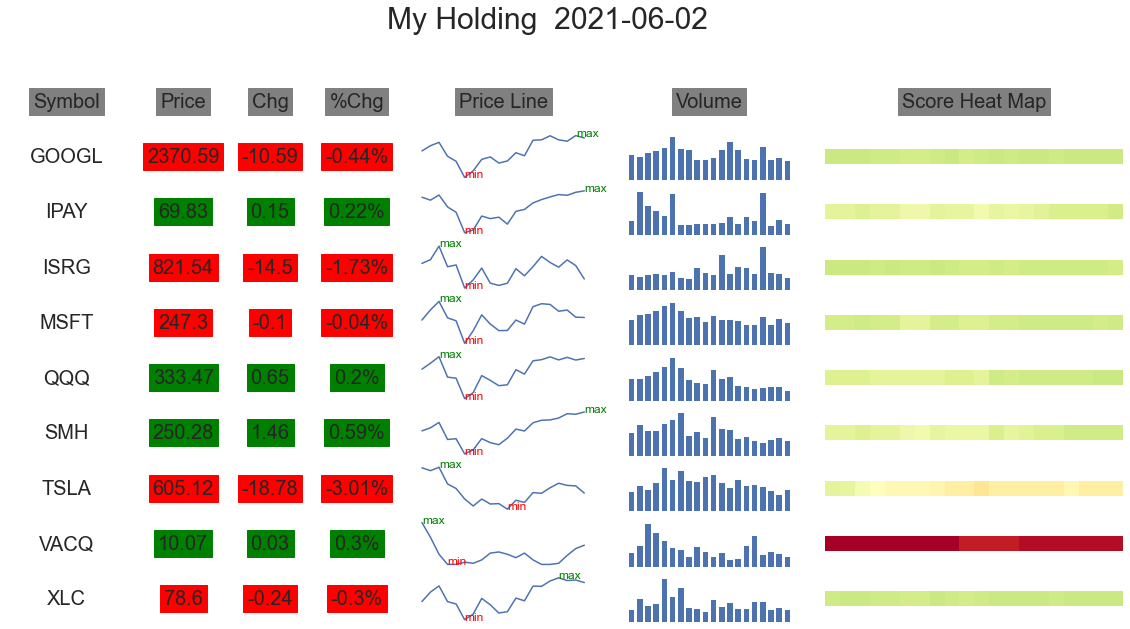

In [17]:
plotStockList(holdingList, tableTitle='My Holding')


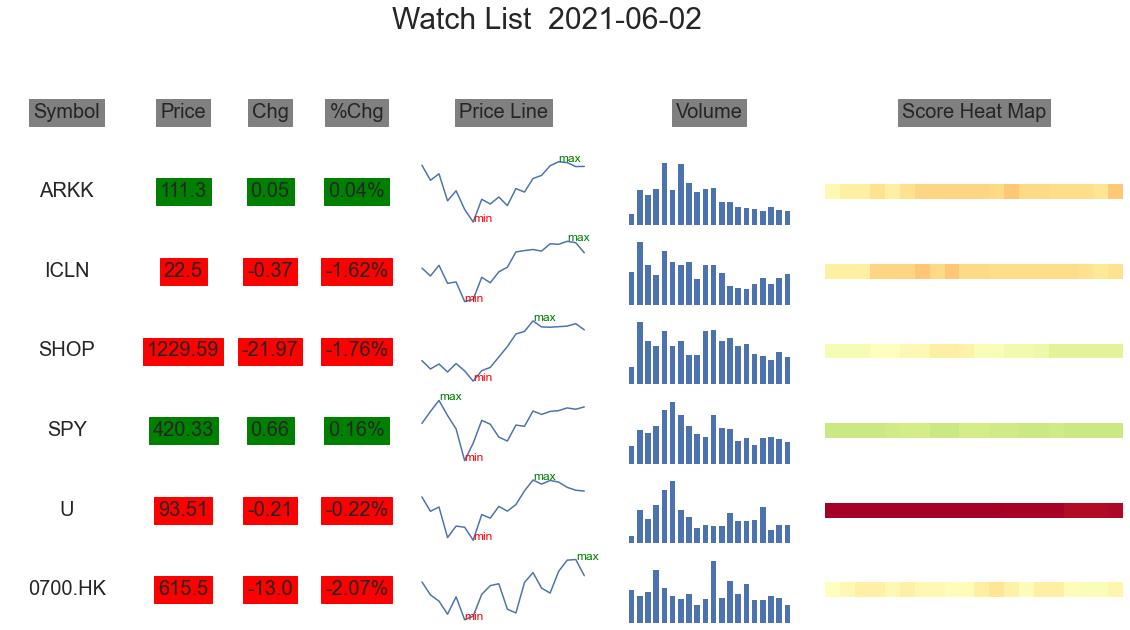

In [18]:
plotStockList(watchList, tableTitle="Watch List")


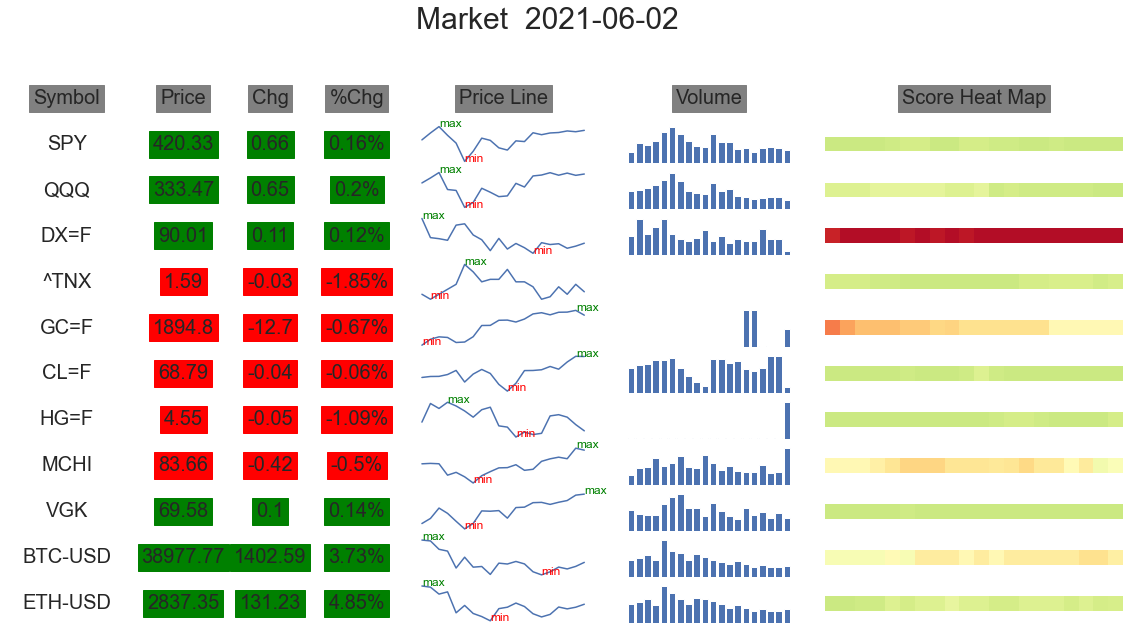

In [22]:
market = [
    Stock('SPY'),
    Stock('QQQ'),
    Stock('DX=F'),
    Stock('^TNX'),
    Stock('GC=F'),  # Gold
    Stock('CL=F'),  # Oil
    Stock('HG=F'),  # Copper
    Stock('MCHI'),  # China
    Stock('VGK'),  # EUROP
    Stock('BTC-USD'),
    Stock('ETH-USD')
]
plotStockList(market, 'Market')


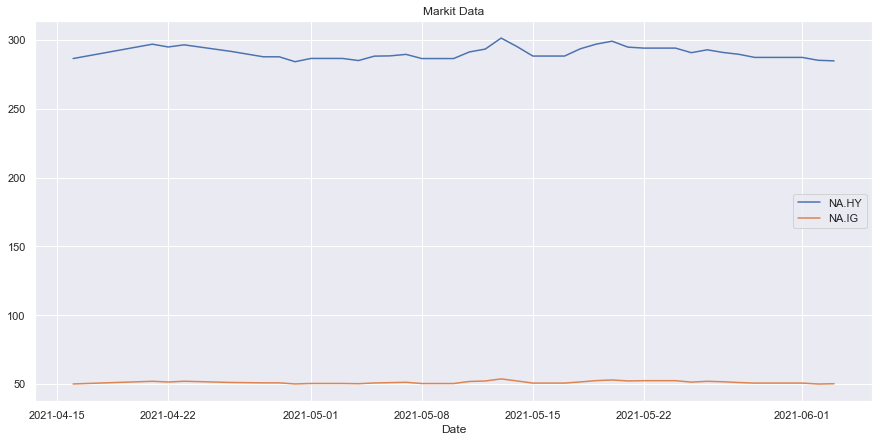

In [20]:
plotMarkitData()

Timestamp('2011-07-01 00:00:00')

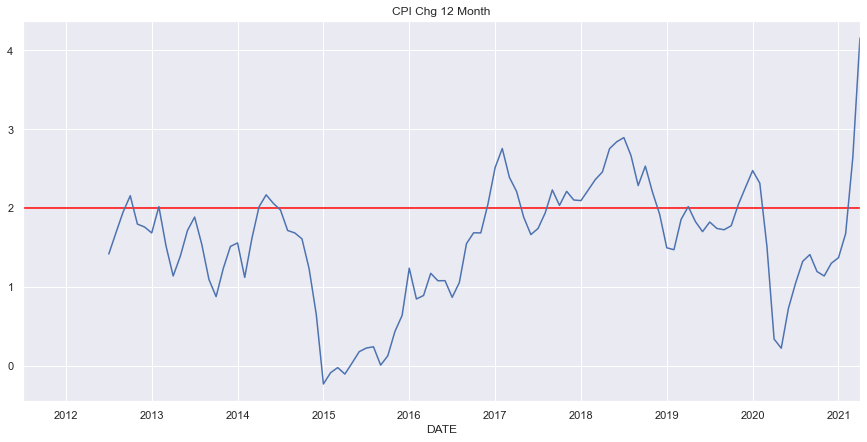

In [67]:
cpiend = datetime.date.today()
cpistart = cpiend - datetime.timedelta(3650)
cpi = web.DataReader('CPIAUCSL', 'fred', cpistart, cpiend)
cpi12=[None]*12
cpilist=cpi['CPIAUCSL']
for i in range(12,len(cpi)):
    chg=(cpi.iloc[i]['CPIAUCSL']-cpi.iloc[i-12]['CPIAUCSL'])*100/cpi.iloc[i-12]['CPIAUCSL']
    cpi12.append(chg)
cpi['Chg12']=cpi12
cpi['Chg12'].plot(figsize=(15, 7),title='CPI Chg 12 Month')
plt.hlines(2,cpi.index[0],cpi.index[-1],colors='red')
cpi.index[0]
